In [2]:
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F
import sys
from sklearn.metrics import accuracy_score, recall_score
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from collections import Counter
import re

In [27]:
def get_landscape_type_by_id(df,i):
    return df.iloc[i, 0]

Results saved to: /home/ubuntu/landscape-aesthetics/data/external/scenicornot/result_of_type_of_landscapes.csv


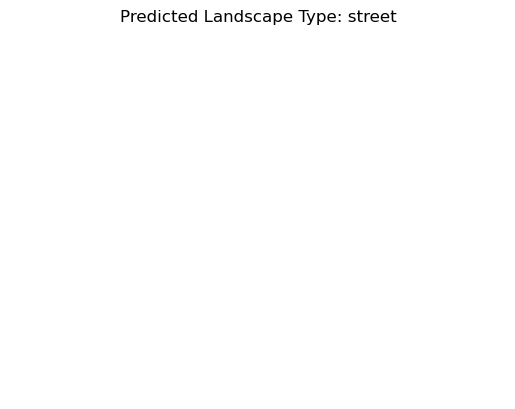

In [31]:
file_location_path = Path.cwd()
project_base_path = file_location_path.parent.parent
scenic_or_not_paths = project_base_path / 'data' / 'external' / 'scenicornot'
image_folder = Path('/home/ubuntu/landscape-aesthetics')

model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 305)
model.load_state_dict(torch.load('../../models/places365_lanscape_type_classification.pth', map_location='cpu', weights_only=True))
model.eval()

data_transforms = transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])
landscape_type_df = pd.read_csv('/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/landscape_categories.csv')  

data = pd.read_csv(os.path.join(scenic_or_not_paths, 'scenicornot.metadata.csv'), usecols = ['filename'])

data = data.sample(n=100, random_state=1)

result = project_base_path / 'data' / 'external' / 'scenicornot' / 'result_of_type_of_landscapes.csv'
image_paths = data.iloc[:, 0].tolist()
predictions = []
image_results = []
    
for img_path in tqdm(image_paths, desc="Processing images"):
    image_path = os.path.join(scenic_or_not_paths, img_path) 
    img_display = Image.open(image_path)
    # plt.imshow(img_display)
    img = data_transforms(Image.open(image_path).convert('RGB')) .unsqueeze(0)
    
    with torch.no_grad():
        output = model(img)
    
    _, predicted = torch.max(output, 1)
    predictions.append(get_landscape_type_by_id(landscape_type_df, predicted.item()))
    image_results.append((img_path, get_landscape_type_by_id(landscape_type_df, predicted.item())))
    plt.title(f"Predicted Landscape Type: {get_landscape_type_by_id(landscape_type_df, predicted.item())}")
    plt.axis('off')
    # plt.show()
results_df = pd.DataFrame(image_results, columns=['image_path', 'prediction'])

results_df.to_csv(result, index=False)
print(f"Results saved to: {result}")